# Normalizing structure factor amplitudes

In subsequent notebooks, we'd like to compare pairs of datasets. The most straightforward way to compare their structure factor amplitudes, $|F_{hkl}|$, is to first normalize them such that the normalized structure factor amplitudes, $|E_{hkl}|$, on average obey $\left<|E|^2\right>=1$.  For various reasons, measured amplitudes do depend on resolution and their average may vary across reciprocal space. Some of these effects are intrinsic to the crystals: molecular disorder and the finite size of atoms lead to a decrease in measured amplitudes with resolution; primary and secondary structure leads to deviations from random atom models. However, to facilitate comparison, we preprocess the data to remove systematic variations in the magnitude of amplitudes across reciprocal space--to the extent that such variation is supported by cross-validation. 

Preprocessing proceeds in four steps:

1. **Basic scaling**. First the $|F|$ and $\sigma_F$ are divided by the average $|F|$.
2. **Simple anisotropic normalization**. An overall scale factor and anisotropic B matrix are fit to maximize the fit to the Wilson distribution (centric and acentric) for normalized amplitudes.
3. **Anisotropic normalization with Fourier corrections.** Any systematic variation across reciprocal space that can be removed using a third- or fourth order Fourier series is removed. 15\% of the data are kept out to determine the optimal order by cross-validation.
4. **Normalization by regression estimates of the scale factor $\Sigma$**. By similar logic, a _k_-nearest neighbor estimator is used to predict the $F^2$ at each location in reciprocal space. The optimal _k_ and weight function are inferred again by cross-validation. We then normalize each structure factor amplitude by its kNN-predicted value.

After this preprocessing, we see that plots of $\left<|E|^2\right>$ versus resolution become flatter and get closer to $1$. 

In [1]:
# General tools
%matplotlib inline

import matplotlib.pyplot as plt
import numpy   as np
import warnings
from mpl_toolkits    import mplot3d
from scipy.stats     import rice, foldnorm, nakagami, gamma 
from scipy.optimize  import least_squares, minimize
from time            import perf_counter

plt.rcParams.update({'figure.figsize': (5,3.5)})
plt.rcParams.update({'font.size': 14})
t_overall_start = perf_counter()

In [2]:
import reciprocalspaceship as rs
import gemmi
from dw_tools import modify_ds, wilson, plots
from dw_tools import aniso_scaling_step_1 as aniso1
from dw_tools import aniso_scaling_step_2 as aniso2
from dw_tools import knn_tools as knn
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors       import KNeighborsRegressor
rs.__version__

'1.0.1'

# Preprocessing of individual datasets
- The entire process for a single dataset takes 2-5 minutes total (up to n=4) or 10-15 min (with n=5).
- We've observed that the preprocessing is, ironically, most complicated for datasets which have been French-Wilson (FW) scaled: in such datasets, noisy reflections are overrepresented near the mean of the Wilson distributions, and this skews normalization. In the second step of anisotropic scaling, I added weights to diminish the effects of the noisy reflections.

In [3]:
%autosave 300
%load_ext autoreload
%autoreload 2

Autosaving every 300 seconds


## Load data

In [4]:
fig_dir = "results_figs/"

In [5]:
# path="double_wilson_data\\" # Windows 
path="double_wilson_data/"    # Unix

data_set_pairs = {0:("5kvx_phases", "5kw3_phases"),\
                  1:("5e1y_phases", "2vwr_phases"),\
                  2:("3pyp_phases", "1nwz_phases"),\
                  3:("1otb_phases_reindexed", "1nwz_phases"),\
                  5:("4eul_phases", "2y0g_phases"),\
                  6:("4kjk_phases", "4kjj_phases", "4pst_phases", "4pss_phases"),\
                  7:("e35cdef_OFF200ns_HD_2sig_varEll","e35cdef_200ns_HD_2sig_varEll"),\
                  8:("NECAT_PTP1B_RT_SAD\\7rin_phases", "NECAT_PTP1B_RT_SAD\\7mm1_phases")}
data_set_labels= {0: 'thaumatin cryo/RT',\
                  1: 'LNX2/PDZ2 RT/cryo',\
                  2: 'PYP cryo-trapped lit; dark',\
                  3: 'PYP 295K/149K',\
                  5: 'EGFP different cryo conditions',\
                  6: 'Keedy/Fraser 2014',\
                  7: 'LNX2/PDZ2: EF-X OFF/ON',\
                  8: 'PTP1B apo/TCS401'\
                 }

#################################################
# Set the example number and the dataset below. #
#################################################

# example 1 fails on kNN regression
example=6
dataset=2
mtz1 = data_set_pairs[example][dataset] # omit .mtz
ds1  = rs.read_mtz(path + mtz1 + ".mtz")

# cleanup:
unpurged_count = ds1.shape[0];   ds1.dropna(inplace=True)
purged_count   = ds1.shape[0]
print(f"Discarded {unpurged_count-purged_count} out of {unpurged_count} records")

Discarded 1555 out of 71709 records


In [6]:
ds1.spacegroup

<gemmi.SpaceGroup("P 21 21 21")>

In [7]:
ds1.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 70154 entries, (0, 0, 2) to (32, 5, 15)
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype      
---  ------       --------------  -----      
 0   FREE         70154 non-null  MTZInt     
 1   FP           70154 non-null  SFAmplitude
 2   SIGFP        70154 non-null  Stddev     
 3   FC           70154 non-null  SFAmplitude
 4   PHIC         70154 non-null  Phase      
 5   FC_ALL       70154 non-null  SFAmplitude
 6   PHIC_ALL     70154 non-null  Phase      
 7   FWT          70154 non-null  SFAmplitude
 8   PHWT         70154 non-null  Phase      
 9   DELFWT       70154 non-null  SFAmplitude
 10  PHDELWT      70154 non-null  Phase      
 11  FOM          70154 non-null  Weight     
 12  FC_ALL_LS    70154 non-null  SFAmplitude
 13  PHIC_ALL_LS  70154 non-null  Phase      
dtypes: MTZInt(1), Phase(5), SFAmplitude(6), Stddev(1), Weight(1)
memory usage: 4.9 MB


The following two cells do some dataset-specific cleanup. 

In [8]:
if (example == 4) & (dataset==1): # - GFP_1.37A only contains intensities
    I = ds1["IMEAN"].to_numpy()
    SIGI = ds1["SIGIMEAN"].to_numpy()
    I[I<=0]=0.0001
    ds1["FP"] = np.sqrt(I)
    ds1["SIGFP"] = 0.5*np.sqrt(SIGI**2/I) #I played with using the Nakagami distribution instead, but it seems that its
                                          # std calculation is not very stable, so using naive error propagation instead.
# if (example == 4) & (dataset==1):
#     ds1["FP"] = ds1["F-obs-filtered"]
#     ds1["SIGFP"] = ds1["SIGF-obs-filtered"]

if (example == 7) & (dataset==2):
    ds1["FP"] = ds1["F-obs-filtered"]
    ds1["SIGFP"] = ds1["SIGF-obs-filtered"]
if (example == 7) & (dataset==3):
    ds1["FP"] = ds1["FMODEL"]
    ds1.spacegroup = gemmi.SpaceGroup("P 21 1 1")
# if (example == 6):
#     ds1["FP"] = ds1["F"]
#     ds1["SIGFP"] = ds1["SigF"]

## Basic scaling

Let's inspect $\left< F \right>$ by resolution bin.

Average observations per bin: 3507.7


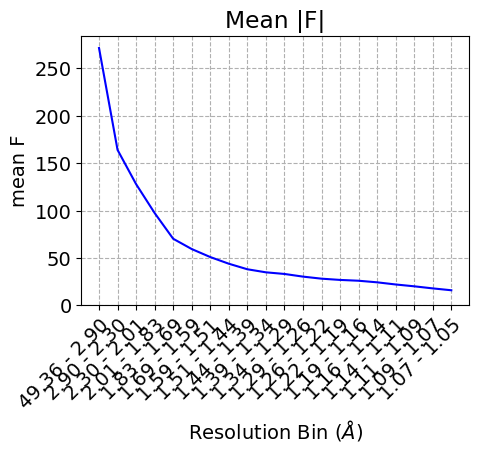

In [9]:
result, bin_labels = plots.compute_meanF_byres(ds1, label="FP", nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result, bin_labels, ylabel="mean F",color='b')
plt.title("Mean |F|")
plt.ylim(0,)
plt.show()

Some very basic scaling:

In [10]:
avg = ds1["FP"].mean()
ds1["FP"] = ds1["FP"]/avg
ds1["SIGFP"] = ds1["SIGFP"]/avg

Additionally, let's add reciprocal lattice point coordinates, ```dHKL```, (a)centric labels, and multiplicities!

In [11]:
modify_ds.ds_add_rs(ds1)
ds1.compute_dHKL(        inplace=True)
ds1.label_centrics(      inplace=True)
ds1.compute_multiplicity(inplace=True);

### Checking reciprocal space (ASU) coverage
Let's see what chunk of reciprocal space these reflections are located in. 

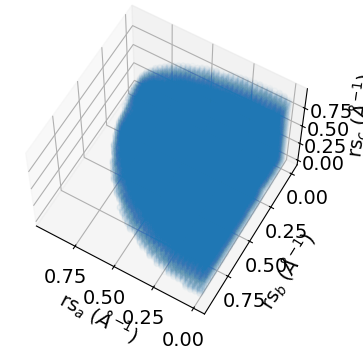

In [12]:
plt.ion
fig = plt.figure(figsize=(6,4))
ax = plt.axes(projection="3d")
ax.scatter3D(ds1["rs_a"], ds1["rs_b"], ds1["rs_c"],alpha=0.02)
ax.view_init(elev=60., azim=1200.)
ax.set_xlabel(r"rs$_a$ ($\AA^{-1}$)")
ax.set_ylabel(r"rs$_b$ ($\AA^{-1}$)")
ax.set_zlabel(r"rs$_c$ ($\AA^{-1}$)")
plt.draw()

## Simple anisotropic normalization.

First, we fit an anisotropic $B$ factor scaling model to the data using the Wilson distribution as the loss function. This provides our first version of normalized structure factors. Numerical warnings are typically inconsequential.

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    res = minimize(         aniso1.anisotropic_scaling_to_1_wilson_loss, [0,0,0,0,0,0,1],\
                                                                method='L-BFGS-B',jac=True,args=(ds1,"FP"))
res_test, ep1, sigep1 = aniso1.anisotropic_scaling_to_1_wilson_loss(res.x, ds1, label="FP", nargout=3)
print("Optimal scaling parameters: ")
print(res.x)

ds1["EP_1_aniso_1"] = ep1
ds1["SIGEP_1_aniso_1"] = sigep1
ds1_unfiltered = ds1
# ds1_unfiltered.info()

Optimal scaling parameters: 
[-3.26068405e+00 -2.49077444e-02  2.33020720e-03 -3.41497092e+00
  4.10700429e-02 -2.98488609e+00  2.18231424e-01]


In [14]:
# there are a few really large outliers which we'll discard so they don't warp further analysis
if (example == 6):
    tmp=(ep1 < np.percentile(ep1,99.99)) & (sigep1<0.4)
    ds1 = ds1[tmp]
    ep1 = ep1[tmp]
    sigep1 = sigep1[tmp]
    # ds1.info()

### Inspection of histograms. 
Some of the example datasets retrieved from the PDB appear to contain structure factor amplitudes after French-Wilson (FW) correction. Ironically, this can make the histograms less likely to follow Wilson statistics because noisy observations are pulled towards the mean of the Wilson distribution (by the way, these are two different Wilsons!). As a result, the histograms of these datasets display some depletion of very small amplitudes and an increase in the number of amplitudes with magnitudes near 1. 

Here, we visualize histograms of our structure factor amplitudes after scaling by an anisotropic B factor. We allow for filtering by $\sigma_F$ to disregard noisy amplitudes that will be particularly affected by FW corrections. When we omit these noisy reflections, we often see that the histogram is a bit shifted relative the Wilson distribution, suggesting that noisy reflections have skewed normalization.

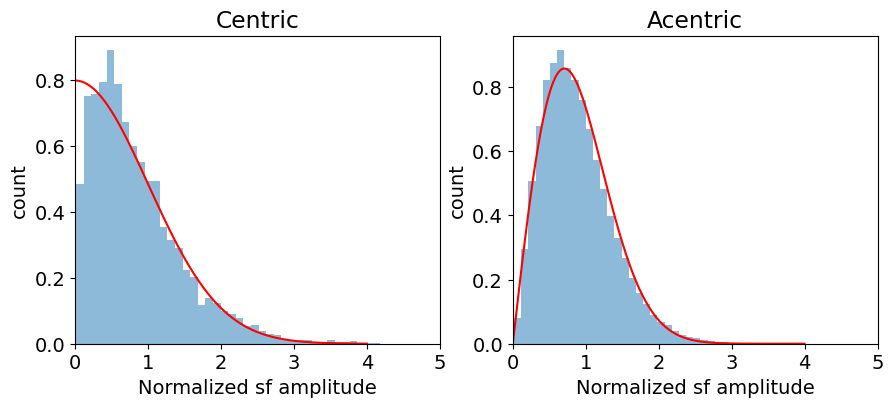

In [15]:
sig_cut = 0.5 

x=np.linspace(0,4,500)
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.hist(ep1[(ds1["CENTRIC"]==True) & (sigep1<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x,wilson.wilson_dist_normalized(x,centric=True),'r-') 
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5])
plt.title("Centric")

plt.subplot(1,3,2)
plt.hist(ep1[(ds1["CENTRIC"]==False) & (sigep1<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x,centric=False),'r-')
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5])
plt.title("Acentric"); 

# plt.savefig(fig_dir + data_set_pairs[example][dataset] + "_histograms_after_aniso_1.svg")
plt.show()

## Anisotropic normalization with Fourier corrections

Often, datasets at this point still show slowly varying average amplitudes across reciprocal space.
In this section, we calculate a pattern of correction coefficients in reciprocal space that improves upon the above anisotropic scaling corrections. We do so using a Fourier series. That is, 

$$
C_{hkl} = A_0 + \sum_{m,n,p} A_{mnp} \cos(2\pi h^T m/L) + B_{mnp} \sin(2\pi h^T m/L)
$$

with $h=(h,k,l)$ the Miller indices and $m=(m,n,p)$ the 3D Fourier component indices. We test the optimal order of the Fourier series by cross-validation (the upper limit for $m,n,p$).

In [16]:
rseed=1763
np.random.seed(rseed)
ds1["test_flag"] = (np.random.random((ds1.shape[0],1)) <0.85)

/tmp/ipykernel_1869509/3713911548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds1["test_flag"] = (np.random.random((ds1.shape[0],1)) <0.85)


In [17]:
# typically the minimum is for n=3 or 4...
# see right below for typical run times by n (n=4: 2-3 min total)
# note that at higher values of n sometimes NaNs pop up

res=[0] # start with a dummy so next entries match their n
n_best = 0
best_loss = 9e9
for n in [1,2,3,4]:
    t1_start = perf_counter()
    params = aniso2.prepare_for_FFT(ds1, n=n, label="EP_1_aniso_1")
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        init_guess = np.zeros((1,2*(n**3)))
        if n>1:
            init_guess[0,:res[-1].x.shape[0]]=res[-1].x
        else:
            init_guess[0]=np.array([1, 0])
        res_tmp = minimize(aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast, \
                           init_guess.flatten(),method='L-BFGS-B', jac = True, \
                           args=(params,ds1["test_flag"].to_numpy()))
        res.append(res_tmp)
        res_test = aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast(res_tmp.x, \
                                          params, bUse=~ds1["test_flag"].to_numpy(), nargout=1)
        if res_test[0] < best_loss:
            best_loss = res_test[0]
            n_best = n
        print(f"For n = {n} the test loss = {res_test[0]:.6}")
        t1_stop = perf_counter()  
        print(f"Elapsed time: {t1_stop-t1_start:.4} s")

For n = 1 the test loss = 12056.8
Elapsed time: 0.263 s
For n = 2 the test loss = 10953.7
Elapsed time: 3.618 s
For n = 3 the test loss = 10796.1
Elapsed time: 12.73 s
For n = 4 the test loss = 10735.9
Elapsed time: 74.81 s


In [18]:
print(n_best)

4


In [19]:
# run for best n using *all* reflections and save
params = aniso2.prepare_for_FFT(ds1, n=n_best, label="EP_1_aniso_1")

loss, ep1, sigep1, scale1 = aniso2.anisotropic_scaling_to_1_FFT_wilson_loss_fast(res[n_best].x, params, \
                                                        bUse=np.ones((ds1.shape[0],),dtype=bool), nargout=3)
EP1_label = "EP_1_aniso_2"
ds1[EP1_label]   = ep1
print(ep1)
ds1["SIG" + EP1_label]= sigep1
print("Centric and acentric mean square amplitudes (1 for perfect normalized SF amplitudes):")
print(np.mean(ep1[ds1["CENTRIC"]==True]**2))
print(np.mean(ep1[ds1["CENTRIC"]==False]**2))

[0.29391026 0.38127506 1.71506261 ... 0.50664925 1.46971063 0.4401441 ]
Centric and acentric mean square amplitudes (1 for perfect normalized SF amplitudes):
1.018703566225427
0.9681645270860084


/tmp/ipykernel_1869509/2824765123.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds1[EP1_label]   = ep1
/tmp/ipykernel_1869509/2824765123.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds1["SIG" + EP1_label]= sigep1


Graphical inspection:

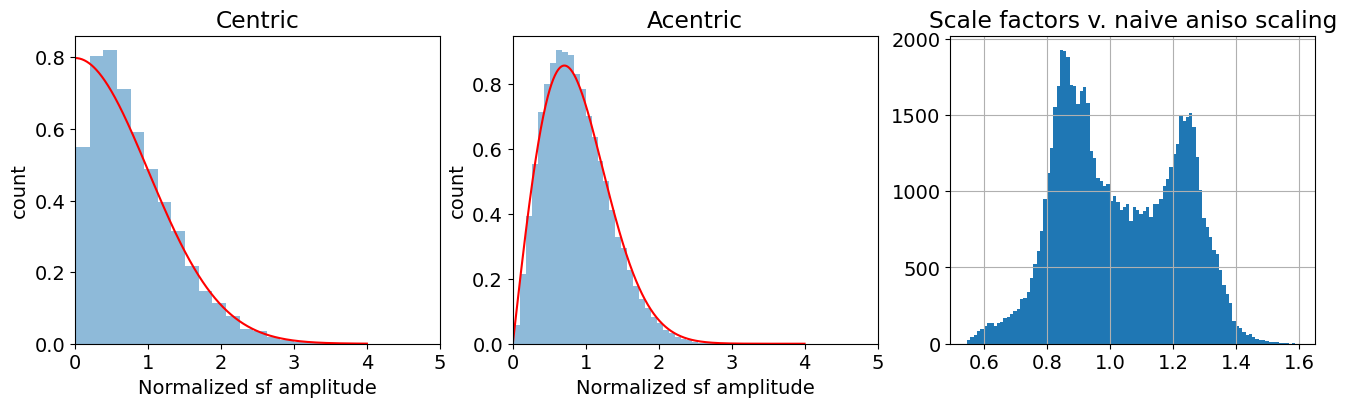

3.644163451749275
2.9744661446315255


In [20]:
sig_cut = 0.5 # noisy observations deviate significantly from the Wilson distribution!
              # ironically, French-Wilson scaling seems to blame.

x=np.linspace(0,4,500)
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.hist(ep1[(ds1["CENTRIC"]==True) & (sigep1<sig_cut)],20,alpha=0.5,density=True)
plt.plot(x,wilson.wilson_dist_normalized(x,centric=True),'r-') 
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5]); plt.title("Centric")

plt.subplot(1,3,2)
plt.hist(ep1[(ds1["CENTRIC"]==False) & (sigep1<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x,centric=False),'r-')
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5]); plt.title("Acentric"); 

plt.subplot(1,3,3)
plt.hist(scale1,100); plt.grid()
plt.title("Scale factors v. naive aniso scaling")

# plt.savefig(fig_dir + data_set_pairs[example][dataset] + "_histograms_after_aniso_2.svg")
plt.show()

print(np.percentile(ep1[(ds1["CENTRIC"]==True) & (sigep1<sig_cut)],99.99))
print(np.percentile(ep1[(ds1["CENTRIC"]==False) & (sigep1<sig_cut)],99.99))

## 4. Normalization by regression estimates of the scale factor $\Sigma$
We will now estimate $\left<|F|^2\right>$ locally in reciprocal space, starting from the Fourier-corrected estimates above. Because the expected intensity is the same for acentric and centric reflections, we can do this estimation for all reflections in one go.

By Rupp eq. (7-104): $ \Sigma_N = \frac{\left<I\right>}{\varepsilon_h} \quad $, so 
                    $\quad \left<I\right>=\varepsilon_h \Sigma_N $

where the multiplicity, $\varepsilon_h$ accounts for differences in expected intensity due only to crystallographic symmetry.

We tried two implementations of $\Sigma$ estimation: using kernel ridge regression and k-nearest neighbors (KNN) with custom weights. The former retains more of the correlation among data sets than the latter, but is **much** slower and more memory-intensive. It crashes on our cluster. Therefore, here we use KNN.

Before doing so, we take a quick look at the multiplicities.

In [21]:
temp = ds1["EPSILON"][ds1["CENTRIC"].to_numpy()==True]
print("Distribution of multiplicities for centric reflections:")
print(temp.value_counts())
print("")

temp = ds1["EPSILON"][ds1["CENTRIC"].to_numpy()==False]
print("Distribution of multiplicities for acentric reflections:")
print(temp.value_counts())

Distribution of multiplicities for centric reflections:
EPSILON
1    5783
2      65
Name: count, dtype: int64

Distribution of multiplicities for acentric reflections:
EPSILON
1    63856
Name: count, dtype: int64


We now perform KNN regression (with self excluded). The optimal $k$ (and uniform weights) are **much higher** when the input have already been anisotropically scaled. Larger $k$ is also slower...

In [278]:
# EP1_label = "EP_1_aniso_1"

In [22]:
gridsearch = True 
ncpu=2 # 8 worked on the cluster
param_grid={"n_neighbors":[50,100,200,400,800, 1200,1600],'weights':['uniform',knn.knn_weight_exp_p05, knn.knn_weight_norm_p05]}
#                                                                   knn.knn_weight_exp_p02, knn.knn_weight_norm_p02, \
#                                                                   knn.knn_weight_exp_p03, knn.knn_weight_norm_p03]}
if gridsearch: 
    knn_1 = GridSearchCV(KNeighborsRegressor(n_jobs=ncpu),param_grid=param_grid)
    knn_1.fit(ds1[["rs_a", "rs_b", "rs_c"]].to_numpy(), (ds1[EP1_label].to_numpy()**2)
             ) # these should be corrected for eps already
else:
    knn_1 = KNeighborsRegressor(800, weights=knn.knn_weight_exp_p05,n_jobs=ncpu)
    knn_1.fit(ds1[["rs_a", "rs_b", "rs_c"]], (ds1[[EP1_label]].to_numpy()**2))

if gridsearch:
    print(knn_1.best_params_)

{'n_neighbors': 1600, 'weights': 'uniform'}


In [23]:
Sigma_1 = knn_1.predict(ds1[["rs_a", "rs_b", "rs_c"]].values).reshape(-1,1)

We are now ready to do the final normalization by dividing each amplitude by its expected value based on the KNN estimator above. That estimator only takes in the reciprocal lattice coordinates of each reflection (see the cell above).

In [281]:
E1    = ds1[        EP1_label].to_numpy().reshape(-1,1)/np.sqrt(Sigma_1) # We've already taken care of epsilon above
SIGE1 = ds1["SIG" + EP1_label].to_numpy().reshape(-1,1)/np.sqrt(Sigma_1)

ds1["EP_1_knn"]    = E1
ds1["SIGEP_1_knn"] = SIGE1
scale2 = ds1["EP_1_knn"].to_numpy()/ds1["EP_1_aniso_1"].to_numpy()

C:\Users\Doeke Hekstra\AppData\Local\Temp\ipykernel_30464\1512805967.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds1["EP_1_knn"]    = E1
C:\Users\Doeke Hekstra\AppData\Local\Temp\ipykernel_30464\1512805967.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds1["SIGEP_1_knn"] = SIGE1


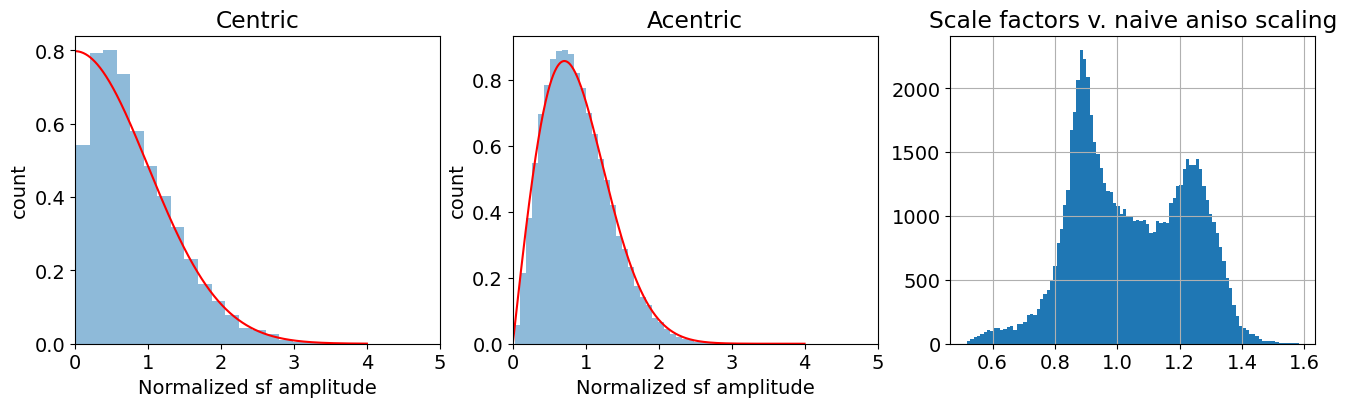

In [282]:
sig_cut = 0.5 # noisy observations deviation significantly from the Wilson distribution!
              # ironically, French-Wilson scaling seems to blame.

x=np.linspace(0,4,500)
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.hist(E1[(ds1["CENTRIC"]==True) & (sigep1<sig_cut)],20,alpha=0.5,density=True)
plt.plot(x,wilson.wilson_dist_normalized(x,centric=True),'r-') 
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5]); plt.title("Centric")

plt.subplot(1,3,2)
plt.hist(E1[(ds1["CENTRIC"]==False) & (sigep1<sig_cut)],40,alpha=0.5,density=True)
plt.plot(x, wilson.wilson_dist_normalized(x,centric=False),'r-')
plt.ylabel("count"); plt.xlabel("Normalized sf amplitude")
plt.xlim([0,5]); plt.title("Acentric"); 

plt.subplot(1,3,3)
plt.hist(scale2,100); plt.grid()
plt.title("Scale factors v. naive aniso scaling")
plt.savefig(fig_dir + data_set_pairs[example][dataset] + "_histograms_after_knn.svg")
plt.show()

# Analysis

To check how well we have removed resolution-dependent systematic variation, we plot |E| as a function of resolution. 

Average observations per bin: 3485.2
Average observations per bin: 3485.2
Average observations per bin: 3485.2
Average observations per bin: 3485.2


(0.0, 2.187773129925055)

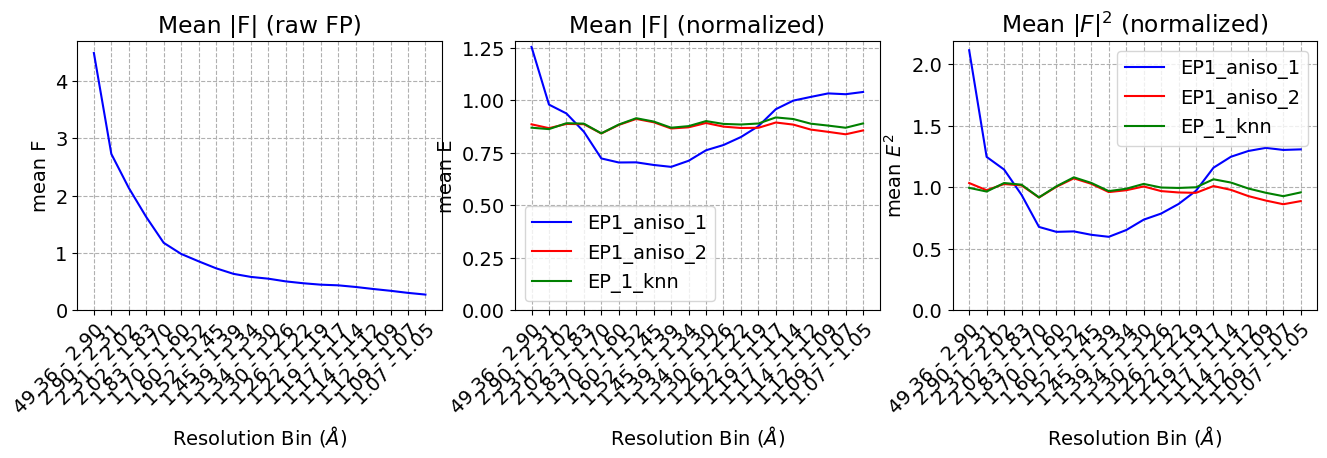

In [283]:
plt.figure(figsize=(16,3.5))
plt.subplot(1,3,1)
result, bin_labels = plots.compute_meanF_byres(ds1, label="FP", nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result, bin_labels, ylabel="mean F",color='b')
plt.title("Mean |F| (raw FP)")
plt.ylim(0,)

plt.subplot(1,3,2)
result_1, bin_labels_1 = plots.compute_meanF_byres(ds1, label="EP_1_aniso_1", nbins=20,sigma_cut=0)
result_2, bin_labels_2 = plots.compute_meanF_byres(ds1, label="EP_1_aniso_2", nbins=20,sigma_cut=0)
result_3, bin_labels_3 = plots.compute_meanF_byres(ds1, label="EP_1_knn",     nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result_1, bin_labels_1, ylabel="mean E",color='b')
plots.plot_by_res_bin(result_2, bin_labels_2, ylabel="mean E",color='r')
plots.plot_by_res_bin(result_3, bin_labels_2, ylabel="mean E",color='g')
plt.title("Mean |F| (normalized)")
plt.legend(["EP1_aniso_1", "EP1_aniso_2","EP_1_knn"])
plt.ylim(0,)

plt.subplot(1,3,3)
result_1, bin_labels_1 = plots.compute_meanFsq_byres(ds1, label="EP_1_aniso_1", nbins=20,sigma_cut=0)
result_2, bin_labels_2 = plots.compute_meanFsq_byres(ds1, label="EP_1_aniso_2", nbins=20,sigma_cut=0)
result_3, bin_labels_3 = plots.compute_meanFsq_byres(ds1, label="EP_1_knn",     nbins=20,sigma_cut=0)
plots.plot_by_res_bin(result_1, bin_labels_1, ylabel=r"mean $E^2$",color='b')
plots.plot_by_res_bin(result_2, bin_labels_2, ylabel=r"mean $E^2$",color='r')
plots.plot_by_res_bin(result_3, bin_labels_2, ylabel=r"mean $E^2$",color='g')
plt.title(r"Mean $|F|^2$ (normalized)")
plt.legend(["EP1_aniso_1", "EP1_aniso_2","EP_1_knn"])
plt.ylim(0,)

In the middle and right panels, we see that individual preprocessing steps have flattened the mean |E|, and its square. Now, we examine the distribution of resolution and |E|. 

Let's now look at the distribution of normalized amplitudes across _marginal_ percentile bins. If the normalization worked well, these 2D histograms are relatively uniform. Deviations highlight limitations of the normalization. Typically the most pronounced effect is depletion of low amplitudes & overrepresentation of amplitudes around the mode of the distribution at high resolution. This is an artifact of French-Wilson scaling.

C:\Users\Doeke Hekstra\AppData\Local\Temp\ipykernel_30464\1991574613.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["dHKL_bin"] = d_dig.flatten()
C:\Users\Doeke Hekstra\AppData\Local\Temp\ipykernel_30464\1991574613.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["EP_1_bin"] = ep1_dig.flatten()


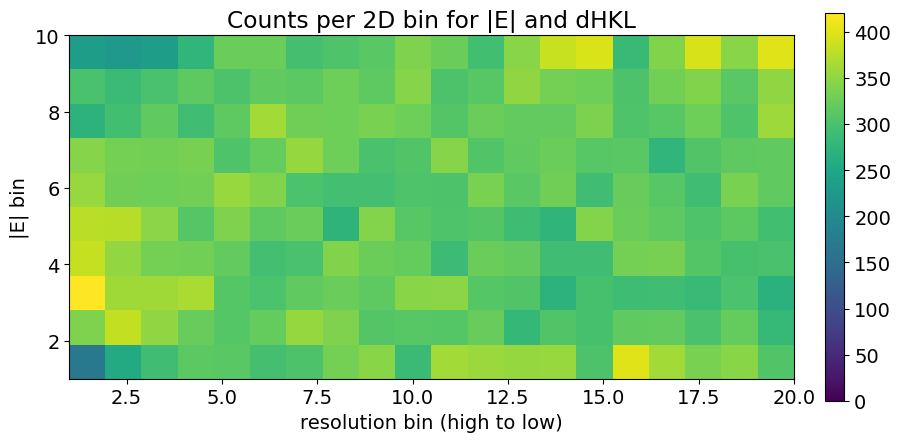

In [284]:
sig_cut = 2 # upper limit of sigF for inclusion in the 2D histogram
nbin    = (20,10)

tmp=ds1.loc[(ds1["CENTRIC"]==False) & (ds1["SIG" + EP1_label]<sig_cut), :]

cdf_bins     = np.linspace(0,100,nbin[0]+1)
d_bins       = np.percentile(tmp["dHKL"], cdf_bins)
d_bins[-1]   = d_bins[-1]+1e-6   # to avoid omitting the largest data point
d_dig        = np.digitize(tmp["dHKL"], d_bins)
tmp["dHKL_bin"] = d_dig.flatten()

cdf_bins     = np.linspace(0,100,nbin[1]+1)
ep1_bins     = np.percentile(tmp[EP1_label], cdf_bins)
ep1_bins[-1] = ep1_bins[-1]+1e-6 # to avoid omitting the largest data point
ep1_dig      = np.digitize(tmp["EP_1_aniso_2"], ep1_bins)
tmp["EP_1_bin"] = ep1_dig.flatten()

H, xedges, yedges = np.histogram2d(tmp.loc[:, "dHKL_bin"], \
                                   tmp.loc[:, "EP_1_bin"],bins=nbin)

plt.figure(figsize=(10,8))
im=plt.imshow(H.transpose(), interpolation='nearest', origin='lower',\
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmin=0)
plt.xlabel("resolution bin (high to low)")
plt.ylabel("|E| bin")
plt.title("Counts per 2D bin for |E| and dHKL")
plt.colorbar(im,fraction=0.025, pad=0.04)

fname = mtz1 + "_n" + str(n_best) + "_" + EP1_label + "_" + str(rseed)+"_sigcut_" + str(sig_cut)+ ".png"
plt.savefig("results_figs/" + fname)
plt.show()

For example 0 dataset 0, in the high resolution bins, we see the pathology that the |E| are still not cleanly normalized--the distribution is peaked at a certain |E| bin, instead of being flat across all |E| bins. We attribute this to FW corrections.

## Cleaning up 

Finally, we clean up the mtz datatypes before further analysis. 

In [285]:
ds1["FP"]             = ds1["FP"             ].astype("SFAmplitude")
ds1["SIGFP"]          = ds1["SIGFP"          ].astype("Stddev")
ds1["rs_a"]           = ds1["rs_a"           ].astype("MTZReal")
ds1["rs_b"]           = ds1["rs_b"           ].astype("MTZReal")
ds1["rs_c"]           = ds1["rs_c"           ].astype("MTZReal")
ds1["EP_1_aniso_1"]   = ds1["EP_1_aniso_1"   ].astype("NormalizedSFAmplitude")
ds1["EP_1_aniso_2"]   = ds1["EP_1_aniso_2"   ].astype("NormalizedSFAmplitude")
ds1["EP_1_knn"]       = ds1["EP_1_knn"       ].astype("NormalizedSFAmplitude")
ds1["SIGEP_1_aniso_1"]= ds1["SIGEP_1_aniso_1"].astype("Stddev")
ds1["SIGEP_1_aniso_2"]= ds1["SIGEP_1_aniso_2"].astype("Stddev")
ds1["SIGEP_1_knn"]    = ds1["SIGEP_1_knn"    ].astype("Stddev")
ds1["CENTRIC"]        = ds1["CENTRIC"        ].astype("MTZInt")
# ds1.info()

C:\Users\Doeke Hekstra\AppData\Local\Temp\ipykernel_30464\1024371613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds1["FP"]             = ds1["FP"             ].astype("SFAmplitude")
C:\Users\Doeke Hekstra\AppData\Local\Temp\ipykernel_30464\1024371613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds1["SIGFP"]          = ds1["SIGFP"          ].astype("Stddev")
C:\Users\Doeke Hekstra\AppData\Local\Temp\ipykernel_30464\1024371613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy

Let's check whether we still have unsupported column datatypes around!

In [286]:
modify_ds.check_col_dtypes(ds1)

Column "test_flag" has a datatype not supported by the MTZ format.


In [287]:
# We'll have to add centric flags back later
ds1.write_mtz(path + mtz1 + "_scaled.mtz",skip_problem_mtztypes=True)
t_overall_end = perf_counter()
print("Total elapsed time:", t_overall_end-t_overall_start)

Total elapsed time: 16228.5051969


In [288]:
print(mtz1)

4pst_phases
